In [1]:
import sys
import os

# Assumes the current working directory is the 'usage' folder in this repo. 
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)


# Internal imports. 
from blue_rov import Params as ps # blue_rov.py in main folder. 
from diffUV import dyn_body, kin, dyned_eul, dyned_quat # names defined in __init__.py. 
from diffUV.utils.symbols import *
from diffUV.utils.quaternion_ops import euler2q, q2euler

# External imports. 
from casadi import *
import numpy as np
import os
from scipy.spatial.transform import Rotation as R

r_g = vertcat(x_g, y_g, z_g) # center of gravity wrt body origin
r_b = vertcat(x_b, y_b, z_b) # center of buoyancy wrt body origin 
I_o = vertcat(I_x, I_y, I_z,I_xz) # rigid body inertia wrt body origin

decoupled_added_m = vertcat(X_du, Y_dv, Z_dw, K_dp, M_dq, N_dr) # added mass in diagonals
coupled_added_m =  vertcat(X_dq, Y_dp, N_dp, M_du, K_dv, X_dw, Y_dr, Z_dq, K_dr) # effective added mass in non diagonals

linear_dc = vertcat(X_u, Y_v, Z_w, K_p,  M_q, N_r) # linear damping coefficients
quadratic_dc = vertcat(X_uu, Y_vv, Z_ww, K_pp, M_qq, N_rr) # quadratic damping coefficients

n0 = vertcat(n, dn) # state variables wrt ned

# body representaion
uv_body = dyn_body()



In [3]:
Kinematics = kin()
Jq_ = Kinematics.Jq
J_ = Kinematics.J

# integration of the body dynamics
Jq_dot = Kinematics.Jq_dot
v_ddot = uv_body.body_forward_dynamics()
# Diff eqs. for the body dynamics
xd = Jq_@x_nb # differential Velocity. Multiply by x_nb goes to world (NED) frame. 
ode_xdd = v_ddot # acceleration in body. 

rhs = vertcat(xd, ode_xdd) #the complete ODE vector


f_rhs = Function('Odefunc', [m, W, B, r_g, r_b, I_o,
                           decoupled_added_m, coupled_added_m,
                           linear_dc, quadratic_dc,
                           x_nb, n, uq, tau_b, v_c], [rhs])

dt = SX.sym("dt")

n_arg = vertcat(p_n, q2euler(uq))
f_rhs_simplify = f_rhs(ps.m, ps.W, ps.B, ps.rg, ps.rb, ps.Io, ps.added_m,
                       ps.coupl_added_m, ps.linear_dc, ps.quadratic_dc, x_nb,  n_arg, uq,  tau_b, v_c) # Partial symbolic partial vals. Inputs symbolic. 

f_rhs_simplify_func = Function('f_ode_simplify', [x_nb , uq, tau_b, v_c], [f_rhs_simplify]) ## 

T = 20 # time horizon
N = 1600 # number of control intervals

ode = f_rhs_simplify_func(x_nb ,uq, tau_b, v_c)

# integrator to discretize the system
# Integrator needs resolution. Dt. 
sys = {}
sys['x'] = vertcat(p_n, uq, x_nb) # State 
sys['u'] = tau_b # Inputs 


params = vertcat(dt, v_c) # Parameters 
sys['p'] = params # Resolution. Symbolic so can scale/modify. Parameters. 
sys['ode'] = ode*dt # Time scaling

# Rk is an integration method. rk45. 
intg = integrator('intg', 'rk', sys, 0, 1 , {'simplify':True, 'number_of_finite_elements':100}) # Reduce finite elements to speed up.

xS0 = vertcat(p_n, uq, x_nb) # xyz, wq xq yq zq, u v w p q r, 


res = intg(x0=xS0,u=tau_b, p=params) #evaluate with symbols
x_next = res['xf'] # response in symbolic form. Size of states. 
x_next.size()

# Quaternion normalization
x_next[3:7] = x_next[3:7]/sqrt(x_next[3:7].T@x_next[3:7])  #quaternions requires normalization. Drift from num error. Need to add to 1. 

# Limit the depth of the vehicle
x_next[9] = if_else(x_next[2] < 0, 0,  x_next[9]) # if vehicle on surface, no more up motion
x_next[2] = if_else(x_next[2] < 0, 0,  x_next[2]) # if vehicle on surface, keep on surface and not go up

# Simplify API to (x,u)->(x_next)
F = Function('Vnext',[xS0,tau_b,dt,v_c],[x_next]) # When defining parameters, dont't need to keep structure. 

In [5]:
import math
 
def euler_from_quaternion(q):
        w, x, y, z = q
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return np.array([roll_x, pitch_y, yaw_z]) # in radians

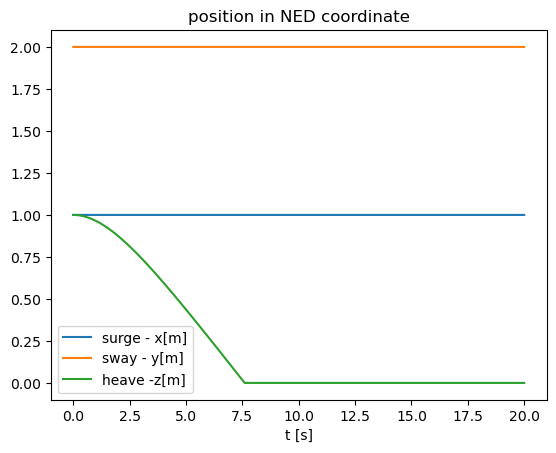

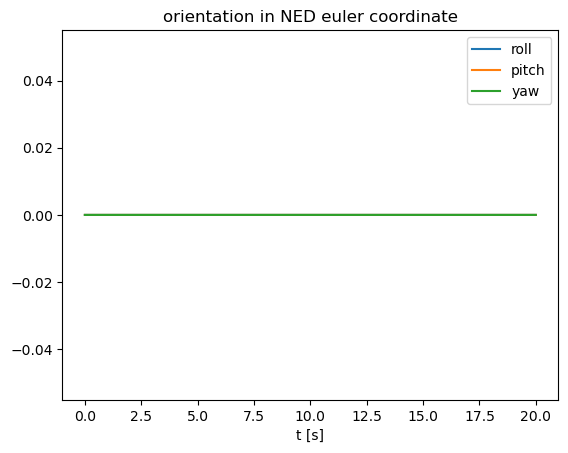

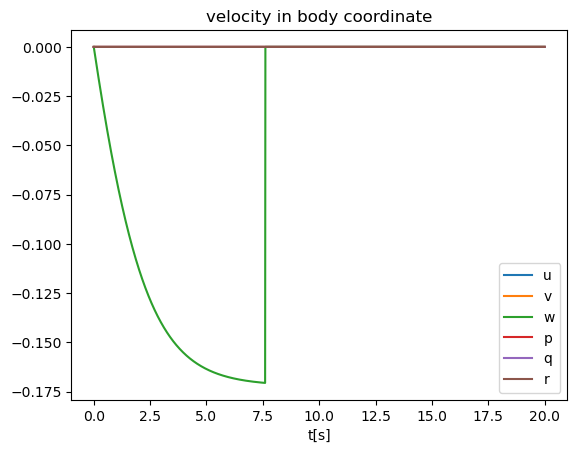

In [6]:
# SIMULATING vehicle on water surface
import matplotlib.pyplot as plt
sim = F.mapaccum(N)# WAy of doing FOR loop. Mostly used when no inputs. If want to include inputs, need actual for loop.
# N is number of iterations performed.

x0 = np.array([1.0, 2.0, 1.0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #x y z w xq yq zq u v w p q r
u0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) # input Forces and moments
v_currents = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) # flow velocity
dt = T/N

res = sim(x0, u0, dt, v_currents)
res.T
t = np.linspace(0, T, N+1)


# Create a figure and plot the data
plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((13,1)), res.toarray()), axis=1)[0:3,:].T)
plt.legend(['surge - x[m]', 'sway - y[m]', 'heave -z[m]'])
plt.title("position in NED coordinate")
plt.xlabel('t [s]')

plt.figure()
vfunc = np.vectorize(euler_from_quaternion, signature='(n)->(k)')
rpy_array = vfunc(np.concatenate((np.array(x0).reshape((13,1)), res.toarray()), axis=1)[3:7,:].T)
plt.plot(t, rpy_array)
plt.legend(['roll', 'pitch', 'yaw'])
plt.title("orientation in NED euler coordinate")
plt.xlabel('t [s]')

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((13,1)), res.toarray()), axis=1)[7::,:].T)
plt.legend(['u', 'v', 'w', 'p', 'q', 'r'])
plt.xlabel('t[s]')
plt.title("velocity in body coordinate")
plt.show()



In [ ]:
F.save('fw_dyn_w_flow.casadi') # Save the function.